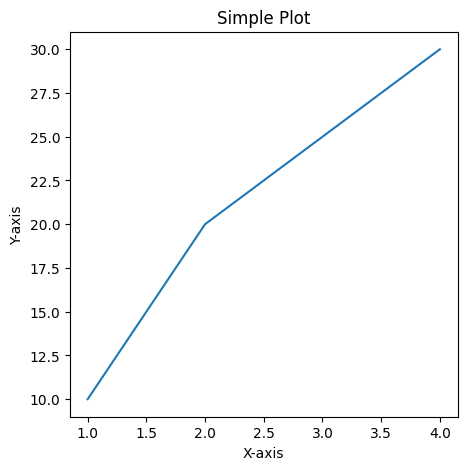

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure inline plotting
%matplotlib inline

# Simple plot example
plt.figure(figsize=(5, 5))
plt.plot([1, 2, 3, 4], [10, 20, 25, 30])
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Simple Plot')
plt.show()


In [3]:
# --------------------------------------------------
# Import Libraries and Set Up Environment
# --------------------------------------------------
import os
import pandas as pd
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import parallel_backend

matplotlib.use('Agg')  # Use 'Agg' backend

# Enable inline plotting
%matplotlib inline

# Set joblib temporary directory
os.environ['JOBLIB_TEMP_FOLDER'] = '/home/nrelab-titan/Desktop/shovon/temp_joblib'

In [4]:
# --------------------------------------------------
# Load and Prepare Data
# --------------------------------------------------
# File paths
plain_terrain_file = '/home/nrelab-titan/Desktop/shovon/data/terrain_analysis/plain_terrain_features.csv'
grass_terrain_file = '/home/nrelab-titan/Desktop/shovon/data/terrain_analysis/grass_terrain_features.csv'

# Load CSV files
plain_terrain_df = pd.read_csv(plain_terrain_file)
grass_terrain_df = pd.read_csv(grass_terrain_file)

plain_terrain_df['label'] = 'plain'
grass_terrain_df['label'] = 'grass'

# Concatenate the DataFrames
combined_df = pd.concat([plain_terrain_df, grass_terrain_df], ignore_index=True)

# Verify the combined DataFrame
print(combined_df.head())


         X         Y         Z   NormalX   NormalY   NormalZ  Intensity  label
0  1.89208 -0.283757 -0.594149  0.054079 -0.063316  0.996527    36.1429  plain
1  1.96072 -0.267909 -0.599250  0.058089 -0.063021  0.996320    35.8889  plain
2  1.91002 -0.202749 -0.590134  0.058065 -0.063081  0.996318    36.0000  plain
3  1.98394 -0.209456 -0.604023  0.064656 -0.062046  0.995977    36.0000  plain
4  1.94386 -0.077196 -0.588291  0.081759 -0.059133  0.994896    36.0000  plain


In [5]:
# --------------------------------------------------
# Feature Extraction and Scaling
# --------------------------------------------------
# Features and labels
features = ['NormalX', 'NormalY']
X = combined_df[features]
y = combined_df['label'].map({'plain': 0, 'grass': 1})

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [6]:
# --------------------------------------------------
# Model Training and Cross-Validation
# --------------------------------------------------
# Initialize LinearSVC
svm = LinearSVC(random_state=42)

# Perform 5-fold cross-validation with parallel processing
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def parallel_cross_val_predict(estimator, X, y, cv, method='predict'):
    with parallel_backend('loky'):
        return cross_val_predict(estimator, X, y, cv=cv, method=method, n_jobs=-1)

# Using parallel processing for cross_val_predict
y_pred = parallel_cross_val_predict(svm, X_scaled, y, skf)
y_decision = parallel_cross_val_predict(svm, X_scaled, y, skf, method='decision_function')

/home/nrelab-titan/Desktop/shovon/.venv/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/nrelab-titan/Desktop/shovon/.venv/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/nrelab-titan/Desktop/shovon/.venv/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/nrelab-titan/Desktop/shovon/.venv/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to

In [7]:
# --------------------------------------------------
# Calculate and Print Metrics
# --------------------------------------------------
# Calculate metrics
accuracy = accuracy_score(y, y_pred)
f1 = f1_score(y, y_pred)
roc_auc = roc_auc_score(y, y_decision)

# Compute TPR, FPR
fpr, tpr, thresholds = roc_curve(y, y_decision)

# Confusion matrix
cm = confusion_matrix(y, y_pred)
tn, fp, fn, tp = cm.ravel()

# Calculate additional metrics
tpr_value = tp / (tp + fn)  # True Positive Rate (Recall)
fpr_value = fp / (fp + tn)  # False Positive Rate

# Print metrics
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"AUC: {roc_auc}")
print(f"TPR: {tpr_value}")
print(f"FPR: {fpr_value}")
print("\nConfusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(y, y_pred, target_names=['plain', 'grass']))


Accuracy: 0.9947625077986523
F1 Score: 0.9954330249803309
AUC: 0.9998428362362751
TPR: 0.994548437287681
FPR: 0.004949144899762543

Confusion Matrix:
[[ 820908    4083]
 [   6058 1105183]]

Classification Report:
              precision    recall  f1-score   support

       plain       0.99      1.00      0.99    824991
       grass       1.00      0.99      1.00   1111241

    accuracy                           0.99   1936232
   macro avg       0.99      0.99      0.99   1936232
weighted avg       0.99      0.99      0.99   1936232



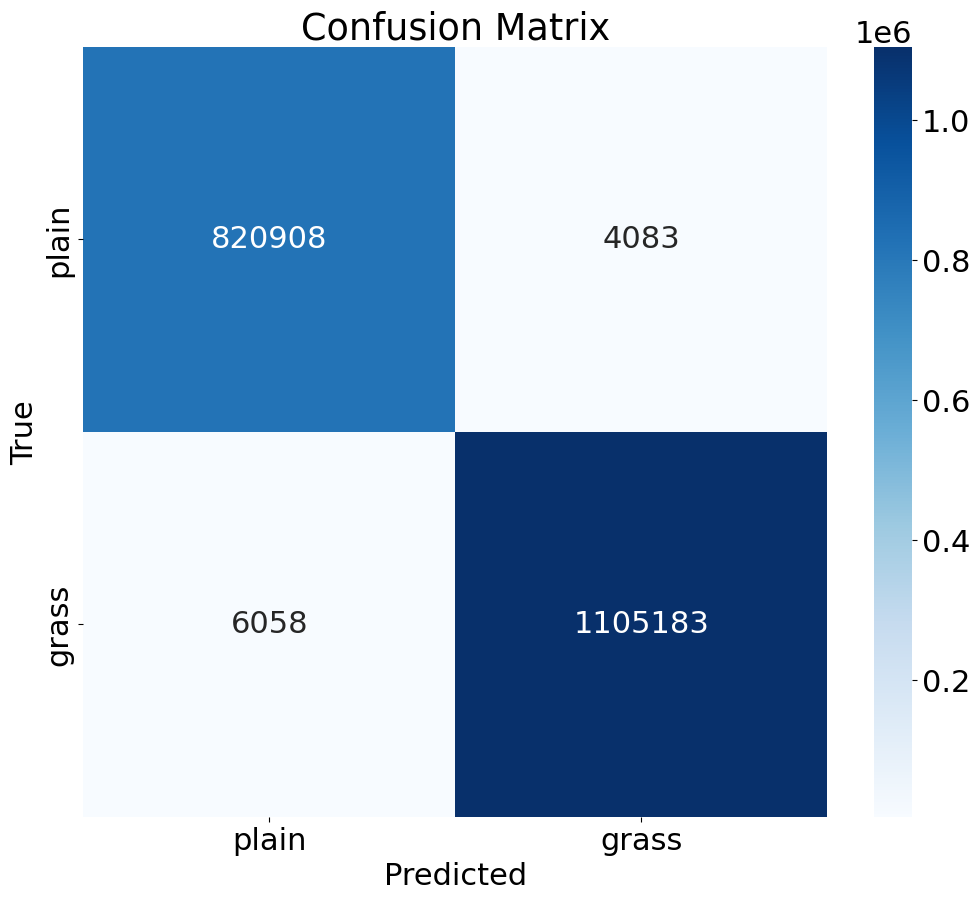

In [8]:
# --------------------------------------------------
# Plot Confusion Matrix
# --------------------------------------------------
# Set the directory where you want to save the plots
plot_save_dir = '/home/nrelab-titan/Desktop/shovon/plots/'

# Ensure the directory exists
os.makedirs(plot_save_dir, exist_ok=True)

# Increase text size for plots
plt.rcParams.update({'font.size': 22})

# Plot Confusion Matrix using Seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['plain', 'grass'], yticklabels=['plain', 'grass'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
confusion_matrix_path = os.path.join(plot_save_dir, 'confusion_matrix.png')
plt.savefig(confusion_matrix_path)
plt.show()

In [9]:
# columns_to_plot = ['X', 'Y', 'Z', 'Intensity', 'NormalX', 'NormalY', 'NormalZ']

# # Function to plot KDE for each column
# def plot_kde(data, column):
#     plt.figure(figsize=(10, 6))
#     sns.kdeplot(data=data, x=column, hue="label", fill=True)
#     plt.title(f'KDE Plot for {column}')
#     plt.savefig(f'kde_{column}.png')
#     plt.show()

# # Plot KDE for each column
# for column in columns_to_plot:
#     plot_kde(combined_df, column)

In [10]:
# from mpl_toolkits.mplot3d import Axes3D
# %matplotlib qt

In [11]:
# # Create a 3D scatter plot
# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111, projection='3d')

# # Map labels to colors
# label_to_color = {'plain': 'b', 'grass': 'g'}
# colors = combined_df['label'].map(label_to_color)

# # Plot the points
# scatter = ax.scatter(
#     combined_df['NormalX'], 
#     combined_df['NormalY'], 
#     combined_df['Intensity'], 
#     c=colors, 
#     label=combined_df['label']
# )

# # Create a legend
# labels = list(label_to_color.keys())
# handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=label_to_color[label], markersize=10) for label in labels]
# ax.legend(handles, labels)

# # Set labels and title
# ax.set_xlabel('Normal X')
# ax.set_ylabel('Normal Y')
# ax.set_zlabel('Intensity')
# ax.set_title('3D Scatter Plot of NormalX, NormalY, and Intensity')

# # Show the plot
# plt.show()

In [12]:
# # Define a function to plot histograms for each feature
# def plot_histograms(df1, df2, feature, feature_name):
#     plt.figure(figsize=(14, 7))

#     plt.subplot(1, 2, 1)
#     sns.histplot(df1[feature], kde=True, bins=30, color='blue', label='Plain Terrain')
#     plt.title(f'{feature_name} Distribution - Plain Terrain')
#     plt.xlabel(feature_name)
#     plt.ylabel('Frequency')

#     plt.subplot(1, 2, 2)
#     sns.histplot(df2[feature], kde=True, bins=30, color='green', label='Grass Terrain')
#     plt.title(f'{feature_name} Distribution - Grass Terrain')
#     plt.xlabel(feature_name)
#     plt.ylabel('Frequency')

#     plt.tight_layout()
#     plt.savefig(f'{feature_name}_Distribution.png')
#     plt.close()

# # Define a function to plot scatter plots for features
# def plot_scatter(df1, df2, feature_x, feature_y, feature_name_x, feature_name_y):
#     plt.figure(figsize=(14, 7))

#     plt.subplot(1, 2, 1)
#     plt.scatter(df1[feature_x], df1[feature_y], color='blue', label='Plain Terrain', alpha=0.5)
#     plt.title(f'{feature_name_x} vs {feature_name_y} - Plain Terrain')
#     plt.xlabel(feature_name_x)
#     plt.ylabel(feature_name_y)

#     plt.subplot(1, 2, 2)
#     plt.scatter(df2[feature_x], df2[feature_y], color='green', label='Grass Terrain', alpha=0.5)
#     plt.title(f'{feature_name_x} vs {feature_name_y} - Grass Terrain')
#     plt.xlabel(feature_name_x)
#     plt.ylabel(feature_name_y)

#     plt.tight_layout()
#     plt.savefig(f'{feature_name_x}_vs_{feature_name_y}.png')
#     plt.close()

# # List of features to visualize
# features = [
#     ('X', 'X Position'),
#     ('Y', 'Y Position'),
#     ('Z', 'Z Position (Height)'),
#     ('NormalX', 'Normal X'),
#     ('NormalY', 'Normal Y'),
#     ('NormalZ', 'Normal Z'),
#     ('Intensity', 'Intensity')
# ]

# # Parallel processing for plotting histograms
# Parallel(n_jobs=-1)(delayed(plot_histograms)(plain_terrain_df, grass_terrain_df, feature, feature_name) for feature, feature_name in features)

# # List of feature pairs to visualize
# scatter_features = [
#     ('X', 'Z', 'X Position', 'Z Position (Height)'),
#     ('Y', 'Z', 'Y Position', 'Z Position (Height)'),
#     ('NormalX', 'NormalY', 'Normal X', 'Normal Y'),
#     ('NormalX', 'NormalZ', 'Normal X', 'Normal Z'),
#     ('NormalY', 'NormalZ', 'Normal Y', 'Normal Z')
# ]

# # Parallel processing for plotting scatter plots
# Parallel(n_jobs=-1)(delayed(plot_scatter)(plain_terrain_df, grass_terrain_df, feature_x, feature_y, feature_name_x, feature_name_y) for feature_x, feature_y, feature_name_x, feature_name_y in scatter_features)

In [13]:
# # Features and labels
# # features = ['NormalX', 'NormalY', 'Intensity']
# features = ['NormalX', 'NormalY']
# X = combined_df[features]
# y = combined_df['label'].map({'plain': 0, 'grass': 1})

# # Standardize the features
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Initialize LinearSVC
# svm = LinearSVC(random_state=42)

# # Perform 5-fold cross-validation with parallel processing
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# def parallel_cross_val_predict(estimator, X, y, cv, method='predict'):
#     with parallel_backend('loky'):
#         return cross_val_predict(estimator, X, y, cv=cv, method=method, n_jobs=-1)

# # Using parallel processing for cross_val_predict
# y_pred = parallel_cross_val_predict(svm, X_scaled, y, skf)
# y_decision = parallel_cross_val_predict(svm, X_scaled, y, skf, method='decision_function')

# # Calculate metrics
# accuracy = accuracy_score(y, y_pred)
# f1 = f1_score(y, y_pred)
# roc_auc = roc_auc_score(y, y_decision)

# # Compute TPR, FPR
# fpr, tpr, thresholds = roc_curve(y, y_decision)

# # Confusion matrix
# cm = confusion_matrix(y, y_pred)
# tn, fp, fn, tp = cm.ravel()

# # Calculate additional metrics
# tpr_value = tp / (tp + fn)  # True Positive Rate (Recall)
# fpr_value = fp / (fp + tn)  # False Positive Rate

In [14]:
# # Print metrics
# print(f"Accuracy: {accuracy}")
# print(f"F1 Score: {f1}")
# print(f"AUC: {roc_auc}")
# print(f"TPR: {tpr_value}")
# print(f"FPR: {fpr_value}")
# print("\nConfusion Matrix:")
# print(cm)
# print("\nClassification Report:")
# print(classification_report(y, y_pred, target_names=['plain', 'grass']))

# # Set the directory where you want to save the plots
# plot_save_dir = '/home/nrelab-titan/Desktop/shovon/plots/terrain_analysis_plots'

# # Ensure the directory exists
# os.makedirs(plot_save_dir, exist_ok=True)

# # Increase text size for plots
# plt.rcParams.update({'font.size': 22})

# # Plot Confusion Matrix using Seaborn
# plt.figure(figsize=(12, 10))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['plain', 'grass'], yticklabels=['plain', 'grass'])
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix')
# plt.savefig('confusion_matrix.png')
# plt.show()

# # Plot ROC Curve
# plt.figure(figsize=(12, 10))
# plt.plot(fpr, tpr, color='blue', lw=3, label=f'ROC curve (area = {roc_auc:.2f})')
# plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve')
# plt.legend(loc="lower right")
# plt.grid()
# plt.savefig('roc_curve.png')
# plt.show()

In [15]:
# # Refit the model to get the coefficients for the decision boundary
# svm.fit(X_scaled, y)

# # # Plot data points and decision boundary in 3D
# # fig = plt.figure(figsize=(12, 10))
# # ax = fig.add_subplot(111, projection='3d')

# # Plot data points and decision boundary in 2D
# fig, ax = plt.subplots(figsize=(12, 10))

# # Map labels to colors
# label_to_color = {0: 'b', 1: 'g'}
# colors = y.map(label_to_color)

# # Plot the points
# # ax.scatter(X_scaled[:, 0], X_scaled[:, 1], X_scaled[:, 2], c=colors, marker='o')
# ax.scatter(X_scaled[:, 0], X_scaled[:, 1], c=colors, marker='o')

# # Create a grid to plot the decision boundary
# xx, yy = np.meshgrid(np.linspace(X_scaled[:, 0].min(), X_scaled[:, 0].max(), 50),
#                      np.linspace(X_scaled[:, 1].min(), X_scaled[:, 1].max(), 50))

# # Plotting the decision boundary in 3D
# # --------------------------------------
# # # Calculate the decision boundary
# # zz = (-svm.intercept_[0] - svm.coef_[0][0] * xx - svm.coef_[0][1] * yy) / svm.coef_[0][2]

# # # Plot the decision boundary
# # ax.plot_surface(xx, yy, zz, color='r', alpha=0.5)

# # # Set labels and title
# # ax.set_xlabel('Normal X')
# # ax.set_ylabel('Normal Y')
# # ax.set_zlabel('Intensity')
# # ax.set_title('3D Scatter Plot with Decision Boundary')

# # plt.show()
# # -------------------------------------

# # Plotting the decision boundary in 2D
# # Calculate the decision boundary
# Z = svm.decision_function(np.c_[xx.ravel(), yy.ravel()])
# Z = Z.reshape(xx.shape)

# # Plot the decision boundary
# contour = ax.contourf(xx, yy, Z, levels=[-1, 0, 1], alpha=0.3, colors=['red', 'blue', 'green'])

# # Set labels and title
# ax.set_xlabel('Normal X')
# ax.set_ylabel('Normal Y')
# ax.set_title('2D Scatter Plot with Decision Boundary')

# plt.show()

In [16]:
# # Function to plot and save the confusion matrix
# def plot_and_save_confusion_matrix(y_true, y_pred, class_labels, filename):
#     """
#     Plots and saves a confusion matrix using Seaborn.

#     Parameters:
#     y_true (array-like): True labels.
#     y_pred (array-like): Predicted labels.
#     class_labels (list): List of class labels.
#     filename (str): Path to save the confusion matrix image.
#     """
#     # Compute confusion matrix
#     cm = confusion_matrix(y_true, y_pred)
    
#     # Create a heatmap
#     plt.figure(figsize=(12, 10))
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    
#     # Add labels and title
#     plt.xlabel('Predicted', fontsize=22)
#     plt.ylabel('True', fontsize=22)
#     plt.title('Confusion Matrix', fontsize=24)
    
#     # Save the plot
#     plt.savefig(filename)
#     plt.close()

# # Assuming y_true and y_pred are your true and predicted labels, and you have two classes: 'plain' and 'grass'
# class_labels = ['plain', 'grass']
# filename = 'confusion_matrix.png'

# plot_and_save_confusion_matrix(y, y_pred, class_labels, filename)